In [146]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# Importing some useful function
import utils

%matplotlib inline

In [147]:
# Loading data and spliting into x and y variables

data = loadmat('ex4Data1.mat')

x, y = data['X'], data['y'].ravel()

y[y == 10] = 0
 
m = y.size

## Visualizing the data

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
The following cell randomly selects 100 images from the dataset and plots them.

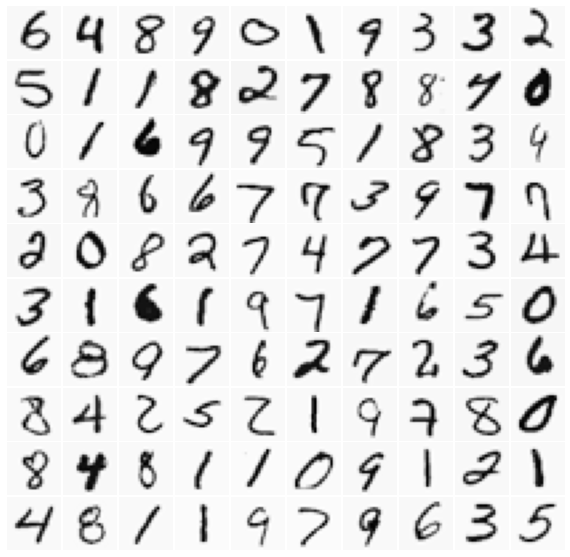

In [148]:
# Displaying our training set (only random 100)

rand_indice = np.random.choice(m, 100, replace=False)

sel = x[rand_indice, :]

utils.displayData(sel)

In [149]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

weights = loadmat('ex4weights.mat')

Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

##  Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

<div class="alert alert-box alert-warning">
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
</div>

Your job is to complete the function `randInitializeWeights` to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```
Note that we give the function an argument for $\epsilon$ with default value `epsilon_init = 0.12`.

In [150]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ====================== YOUR CODE HERE ======================

    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    # ============================================================
    return W

### Sigmoid Gradient

The gradient for the sigmoid function can be computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Now complete the implementation of `sigmoidGradient` in the next cell.
<a id="sigmoidGradient"></a>

In [151]:
def sigmoidGradient(z):

    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
    g = 1 / (1 + np.exp(-z))
    g = g * (1 - g)
    
    # =============================================================
    return g

###  Model representation

Our neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.

You have been provided with a set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

### Feedforward and cost function

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.
</div>
<a id="nnCostFunction"></a>

### Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we
have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size. Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nnCostFunction` and then later add the cost for the regularization terms.

### Backpropagation

![](Figures/ex4-backpropagation.png)

Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop `for t in range(m)` and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $*$ performs element wise multiplication in `numpy`.

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^{(T)} $$

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

<div class="alert alert-box alert-warning">
**Python/Numpy tip**: You should implement the backpropagation algorithm only after you have successfully completed the feedforward and cost functions. While implementing the backpropagation alogrithm, it is often useful to use the `shape` function to print out the shapes of the variables you are working with if you run into dimension mismatch errors.
</div>


**Note:** If the iterative solution provided above is proving to be difficult to implement, try implementing the vectorized approach which is easier to implement in the opinion of the moderators of this course. You can find the tutorial for the vectorized approach [here](https://www.coursera.org/learn/machine-learning/discussions/all/threads/a8Kce_WxEeS16yIACyoj1Q).

In [152]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   x, y, lambda_=0.0):
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    
    #temp_y = np.zeros((m,num_labels))
    #for i,n in enumerate(y):
       # temp = np.zeros(10)
        #temp[n] = 1
       #temp_y[i, :] = temp
        
    yBin = np.zeros((m, num_labels))
    yBin[np.arange(m, step=1), y] = 1
    
    #-----------------Finding Hyphotesis-----------------#
    a1 = x                                                               # (5000, 400)
    a1 = np.concatenate([np.ones((m,1)), x], axis=1)                     # (5000, 401)
    z2 = a1 @ Theta1.T                                                   # (5000, 401) @ (401, 25) => (5000, 25)
    a2 = sigmoid(z2)                                                     # (5000, 25)
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)         # (5000, 26)
    z3 = a2 @ Theta2.T                                                   # (5000, 26) @ (26, 10) => (5000, 10)
    a3 = sigmoid(z3)                                                     # (5000, 10)
    h = a3
    #----------------h is the hyphothesis----------------#
    
    #---------------Finding Cost Function----------------#
    
    theta_one_sum = np.sum(np.sum(Theta1[:, 1:]**2))
    theta_two_sum = np.sum(np.sum(Theta2[:, 1:]**2))
    regularization = (theta_one_sum + theta_two_sum) * (lambda_ / (2 * m))
    
    j = 0
    j_left = -yBin * np.log(h)
    j_right = (1 - yBin) * np.log(1 - h)
    j = np.sum(j_left - j_right) / m
    j = j + regularization
    
    #--------------j is the cost dunction---------------#
    
    #-------------- BackPropegation --------------------#

                #--------Shapes--------#
                ######################## 
                ##                    ##  
                ##  Theta1 (25, 401)  ## 
                ##  Theta2 (10, 26)   ##
                ##  Ybin   (5000, 10) ##
                ##  h      (5000, 10) ##
                ##                    ##
                ########################
                
                
    delta3 = h - yBin                                                # (5000, 10)
    delta2 = delta3 @ Theta2[:, 1:]                                  # (5000, 10) @ (10, 25) => (5000, 25)
    delta2 = delta2 * sigmoidGradient(a1 @ Theta1.T)                 # (5000, 25) * ((5000, 401) @ (401, 25)) => (5000, 25)
    
    Delta1 = delta2.T @ a1                                           # (25, 5000) @ (5000, 401) => (25, 401)
    Delta2 = delta3.T @ a2                                           # (25, 5000) @ (5000, 26) => (25, 26)
    
    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / (2 * m)) * Theta1[:, 1:]
    
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / (2 * m)) * Theta2[:, 1:]
    

    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    #--------------- grad is result -------------------#
    
    
    return j, grad


In [153]:
# Testing our cost function

lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


In [154]:
# Weight regularization parameter (we set this to 1 here).

lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


In [155]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


In [156]:
checkNNGradients(nnCostFunction)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978487e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869427e-05  1.42869443e-05]
 [ 2.33146358e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468731e-04 -2.87468729e-04]
 [-1.37149709e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883235e-05  3.69883234e-05]
 [ 3.35320351e-04  3.35320347e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-6.74798369e-03 -6.74798370e-03]
 [-4.68759764e-05 -4.68759769e-05]
 [-3.76215583e-04 -3.76215587e-04]
 [-1.66560292e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.77867378e-02  5

In [157]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, x, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[-9.27825235e-03 -9.27825236e-03]
 [-1.67679797e-02 -8.38551474e-03]
 [-6.01744725e-02 -3.01747663e-02]
 [-1.73704651e-02 -8.73336556e-03]
 [ 8.89911959e-03  8.89911960e-03]
 [ 3.94334829e-02  1.97238849e-02]
 [-3.19612287e-02 -1.58640412e-02]
 [-5.75658668e-02 -2.87239421e-02]
 [-8.36010761e-03 -8.36010762e-03]
 [ 5.93355565e-02  2.96548091e-02]
 [ 2.49225535e-02  1.23175424e-02]
 [-4.51963845e-02 -2.26667671e-02]
 [ 7.62813550e-03  7.62813551e-03]
 [ 2.47640974e-02  1.24005429e-02]
 [ 5.97717617e-02  3.00535410e-02]
 [ 9.14587966e-03  4.64956337e-03]
 [-6.74798369e-03 -6.74798370e-03]
 [-3.26881426e-02 -1.63675093e-02]
 [ 3.86410548e-02  1.91324196e-02]
 [ 5.46101548e-02  2.72217972e-02]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.18682669e-01  1.41386744e-01]
 [ 2.03987128e-01  1.84277530e-01]
 [ 1.25698067e-01  1.42018701e-01]
 [ 1.76337550e-01  1.63732539e-01]
 [ 1.32294136e-01  1.40931235e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 3.81928711e-05  2.88059211e-02]
 [ 1.17148233e-01  8

In [158]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 290}

#  You should also try different values of lambda
lambda_ = 0.05

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, x, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [159]:
pred = utils.predict(Theta1, Theta2, x)
print(f'Trainin Set Accuracy: {np.mean(pred == y) * 100}%')

Trainin Set Accuracy: 100.0%
